In [1]:
import os
import shutil
import random
from PIL import Image
import cv2

In [2]:
source = '/kaggle/input/rice-leaf-images/rice_images'

brownspot = os.path.join(source, '_BrownSpot')
healthy = os.path.join(source, '_Healthy')
hispa = os.path.join(source, '_Hispa')
leafblast = os.path.join(source, '_LeafBlast')

In [3]:
train = '/kaggle/working/train'
validation = '/kaggle/working/validation'

brownspot_train = os.path.join(train, 'brownspot')
healthy_train = os.path.join(train, 'healthy')
hispa_train = os.path.join(train, 'hispa')
leafblast_train = os.path.join(train, 'leafblast')

brownspot_validation = os.path.join(validation, 'brownspot')
healthy_validation = os.path.join(validation, 'healthy')
hispa_validation = os.path.join(validation, 'hispa')
leafblast_validation = os.path.join(validation, 'leafblast')

if not os.path.exists(train):
    os.mkdir(train)
    os.mkdir(brownspot_train)
    os.mkdir(healthy_train)
    os.mkdir(hispa_train)
    os.mkdir(leafblast_train)

if not os.path.exists(validation):
    os.mkdir(validation)
    os.mkdir(brownspot_validation)
    os.mkdir(healthy_validation)
    os.mkdir(hispa_validation)
    os.mkdir(leafblast_validation)

In [4]:
def split_and_resize(source, destination_train, destination_validation, split_size, img_size):
    files = []
    for filename in os.listdir(source):
        file = source + '/' + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * split_size)
    validation_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[:validation_length]

    for filename in training_set:
        this_file = source + '/' + filename
        destination = destination_train + '/' + filename
        img = Image.open(this_file)
        img = img.resize((img_size, img_size))
        img.save(destination)
    print("Training set of " + source + " created.")

    for filename in validation_set:
        this_file = source + '/' + filename
        destination = destination_validation + '/' + filename
        img = Image.open(this_file)
        img = img.resize((img_size, img_size))
        img.save(destination)
    print("Validation set of " + source + " created.")


split_size = .9
img_size = 224

split_and_resize(brownspot, brownspot_train, brownspot_validation, split_size, img_size)
split_and_resize(healthy, healthy_train, healthy_validation, split_size, img_size)
split_and_resize(hispa, hispa_train, hispa_validation, split_size, img_size)
split_and_resize(leafblast, leafblast_train, leafblast_validation, split_size, img_size)

Training set of /kaggle/input/rice-leaf-images/rice_images/_BrownSpot created.
Validation set of /kaggle/input/rice-leaf-images/rice_images/_BrownSpot created.
Training set of /kaggle/input/rice-leaf-images/rice_images/_Healthy created.
Validation set of /kaggle/input/rice-leaf-images/rice_images/_Healthy created.
Training set of /kaggle/input/rice-leaf-images/rice_images/_Hispa created.
Validation set of /kaggle/input/rice-leaf-images/rice_images/_Hispa created.
Training set of /kaggle/input/rice-leaf-images/rice_images/_LeafBlast created.
Validation set of /kaggle/input/rice-leaf-images/rice_images/_LeafBlast created.


In [5]:
import pandas as pd

df = pd.DataFrame(columns=['Train', 'Validation'])
df['Train'] = [len(os.listdir(brownspot_train)), len(os.listdir(healthy_train)), len(os.listdir(hispa_train)), len(os.listdir(leafblast_train))]
df['Validation'] = [len(os.listdir(brownspot_validation)), len(os.listdir(healthy_validation)), len(os.listdir(hispa_validation)), len(os.listdir(leafblast_validation))]
df.index = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
df

Train  Validation
BrownSpot    470          53
Healthy     1339         149
Hispa        508          57
LeafBlast    701          78

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                      rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(train,
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    target_size=(img_size, img_size))

validation_generator = validation_datagen.flow_from_directory(validation,
                                                                batch_size=10,  
                                                                class_mode='categorical',
                                                                target_size=(img_size, img_size))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Found 3018 images belonging to 4 classes.
Found 337 images belonging to 4 classes.


In [7]:
import tensorflow_hub as hub

pre_trained_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2", trainable=True)

model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')

])

In [8]:
model.build([None, img_size, img_size, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6,608,276
Trainable params: 6,547,668
Non-trainable params: 60,608
_________________________________________________________________


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('rice_disease.h5',
                                monitor='val_acc',
                                mode='max',
                                save_best_only=True,
                                verbose=1)

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [11]:
history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    callbacks=[checkpoint],
                    validation_data=validation_generator)


Epoch 1/50
302/302 [==============================] - ETA: 0s - loss: 1.1429 - acc: 0.5341
Epoch 1: val_acc improved from -inf to 0.60237, saving model to rice_disease.h5
302/302 [==============================] - 100s 129ms/step - loss: 1.1429 - acc: 0.5341 - val_loss: 0.9356 - val_acc: 0.6024
Epoch 2/50
302/302 [==============================] - ETA: 0s - loss: 1.0125 - acc: 0.6040
Epoch 2: val_acc did not improve from 0.60237
302/302 [==============================] - 35s 116ms/step - loss: 1.0125 - acc: 0.6040 - val_loss: 0.9940 - val_acc: 0.5935
Epoch 3/50
302/302 [==============================] - ETA: 0s - loss: 0.9316 - acc: 0.6388
Epoch 3: val_acc improved from 0.60237 to 0.69733, saving model to rice_disease.h5
302/302 [==============================] - 36s 120ms/step - loss: 0.9316 - acc: 0.6388 - val_loss: 0.8018 - val_acc: 0.6973
Epoch 4/50
302/302 [==============================] - ETA: 0s - loss: 0.8899 - acc: 0.6604
Epoch 4: val_acc did not improve from 0.69733
302/302 

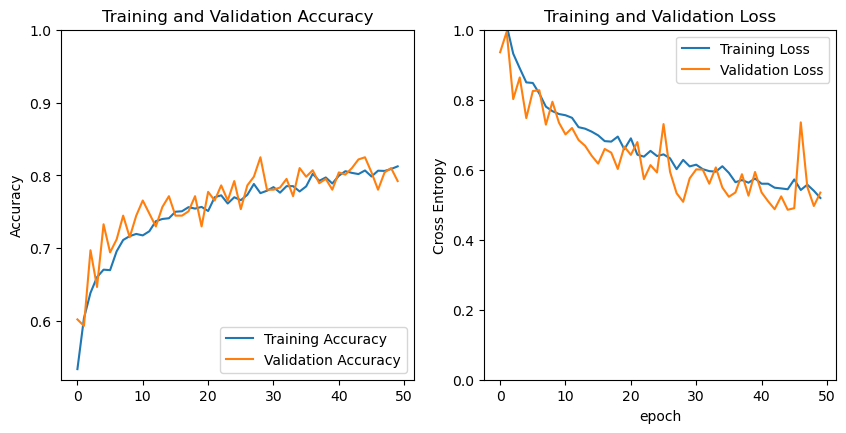

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Found 337 images belonging to 4 classes.
34/34 [==============================] - 1s 19ms/step


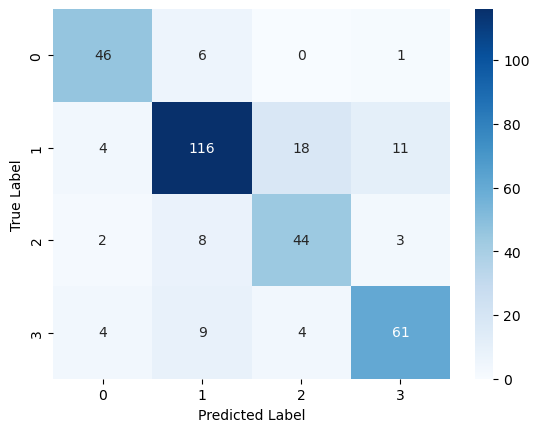

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

test_generator = validation_datagen.flow_from_directory(validation,
                                                        batch_size=10,          
                                                        class_mode='categorical',
                                                        target_size=(img_size, img_size),
                                                        shuffle=False)

test_generator.reset()

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [14]:
print('Classification Report')
target_names = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   BrownSpot       0.82      0.87      0.84        53
     Healthy       0.83      0.78      0.81       149
       Hispa       0.67      0.77      0.72        57
   LeafBlast       0.80      0.78      0.79        78

    accuracy                           0.79       337
   macro avg       0.78      0.80      0.79       337
weighted avg       0.80      0.79      0.79       337



In [15]:
model.save('rice_disease_1.h5')

In [16]:
history_2 = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    callbacks=[checkpoint],
                    validation_data=validation_generator)

Epoch 1/10
302/302 [==============================] - ETA: 0s - loss: 0.5406 - acc: 0.8088
Epoch 1: val_acc did not improve from 0.82493
302/302 [==============================] - 35s 115ms/step - loss: 0.5406 - acc: 0.8088 - val_loss: 0.5756 - val_acc: 0.7745
Epoch 2/10
302/302 [==============================] - ETA: 0s - loss: 0.5309 - acc: 0.8085
Epoch 2: val_acc did not improve from 0.82493
302/302 [==============================] - 34s 114ms/step - loss: 0.5309 - acc: 0.8085 - val_loss: 0.5126 - val_acc: 0.8131
Epoch 3/10
302/302 [==============================] - ETA: 0s - loss: 0.5170 - acc: 0.8188
Epoch 3: val_acc improved from 0.82493 to 0.83086, saving model to rice_disease.h5
302/302 [==============================] - 36s 118ms/step - loss: 0.5170 - acc: 0.8188 - val_loss: 0.4244 - val_acc: 0.8309
Epoch 4/10
302/302 [==============================] - ETA: 0s - loss: 0.5333 - acc: 0.8082
Epoch 4: val_acc did not improve from 0.83086
302/302 [==============================] - 

In [17]:
model.save('rice_disease_2.h5')

Found 337 images belonging to 4 classes.
34/34 [==============================] - 1s 16ms/step


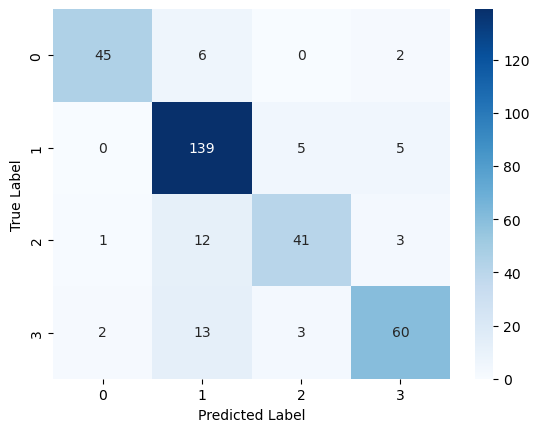

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

test_generator = validation_datagen.flow_from_directory(validation,
                                                        batch_size=10,          
                                                        class_mode='categorical',
                                                        target_size=(img_size, img_size),
                                                        shuffle=False)

test_generator.reset()

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [19]:
print('Classification Report')
target_names = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   BrownSpot       0.94      0.85      0.89        53
     Healthy       0.82      0.93      0.87       149
       Hispa       0.84      0.72      0.77        57
   LeafBlast       0.86      0.77      0.81        78

    accuracy                           0.85       337
   macro avg       0.86      0.82      0.84       337
weighted avg       0.85      0.85      0.84       337



In [20]:
# predict images from other dataset
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

other_source = '/kaggle/input/riceleafs/RiceLeafs/validation/'

Predicting...


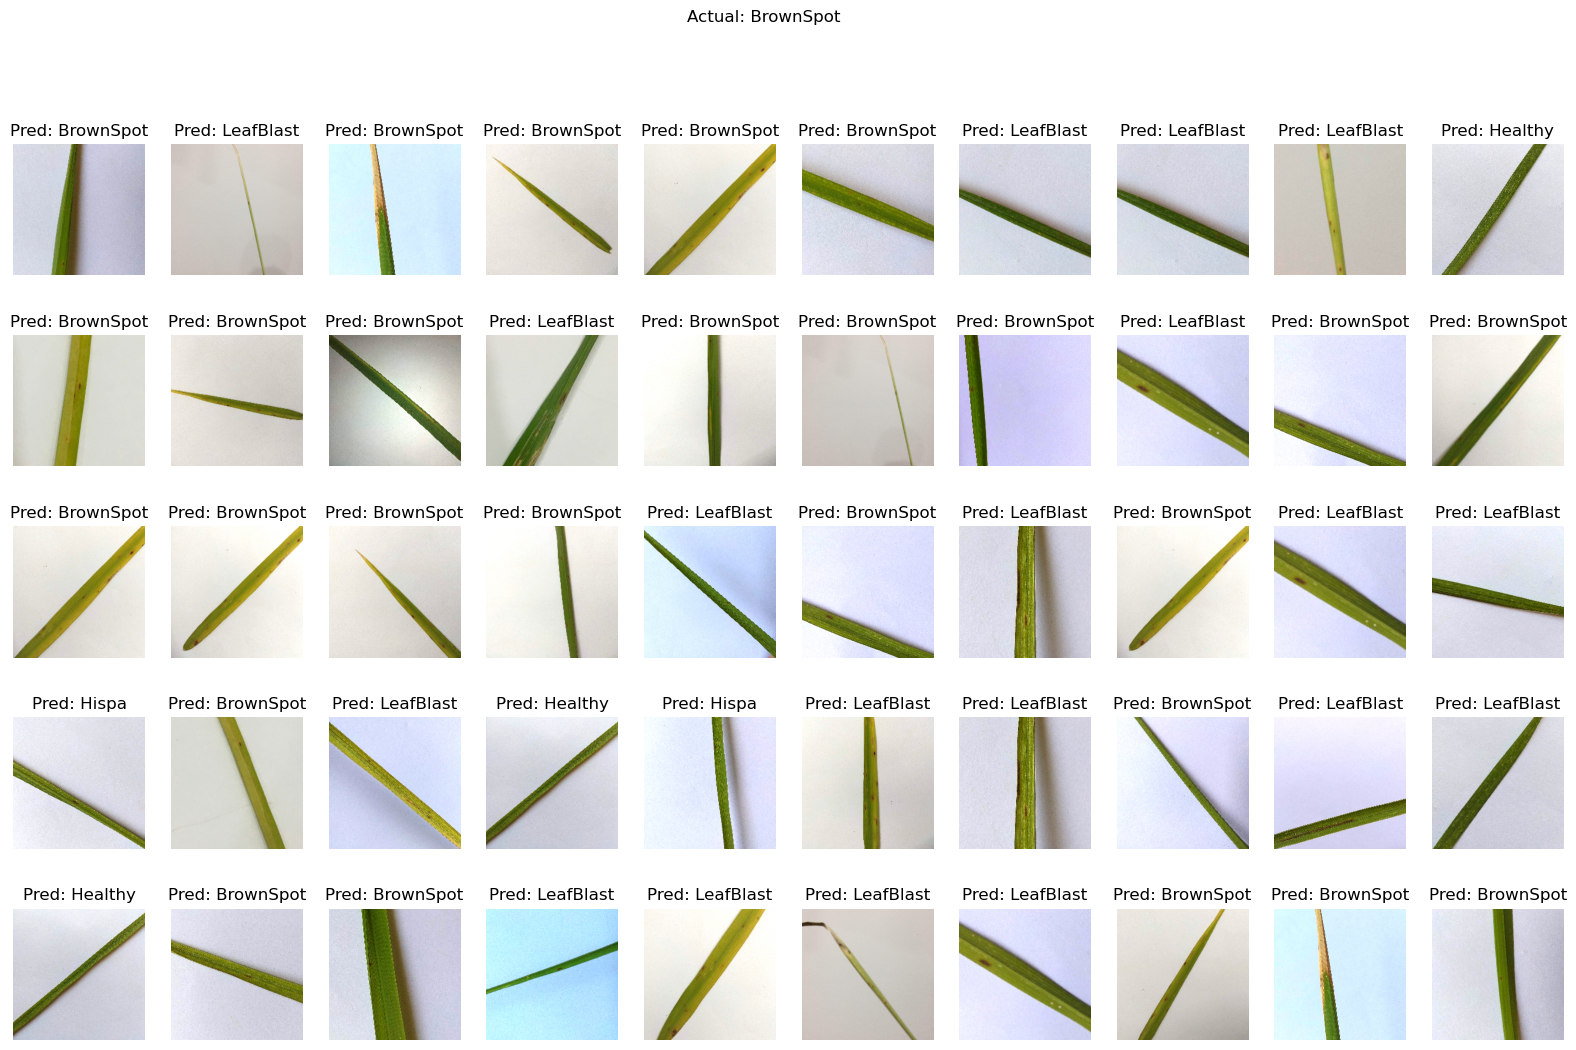

In [21]:
class_names = 'BrownSpot'

files = os.listdir(os.path.join(other_source, class_names))

print('Predicting...')

plt.figure(figsize=(20, 12))
for i in range(50):
    plt.subplot(5, 10, i+1)
    img = random.choice(files)
    img = os.path.join(other_source, class_names, img)
    img = image.load_img(img, target_size=(img_size, img_size))
    img = image.img_to_array(img)
    img = img/255.0
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img, verbose=0)
    plt.title('Pred: ' + target_names[np.argmax(prediction)])
    plt.axis('off')
plt.suptitle('Actual: ' + class_names)
plt.show()

Predicting...


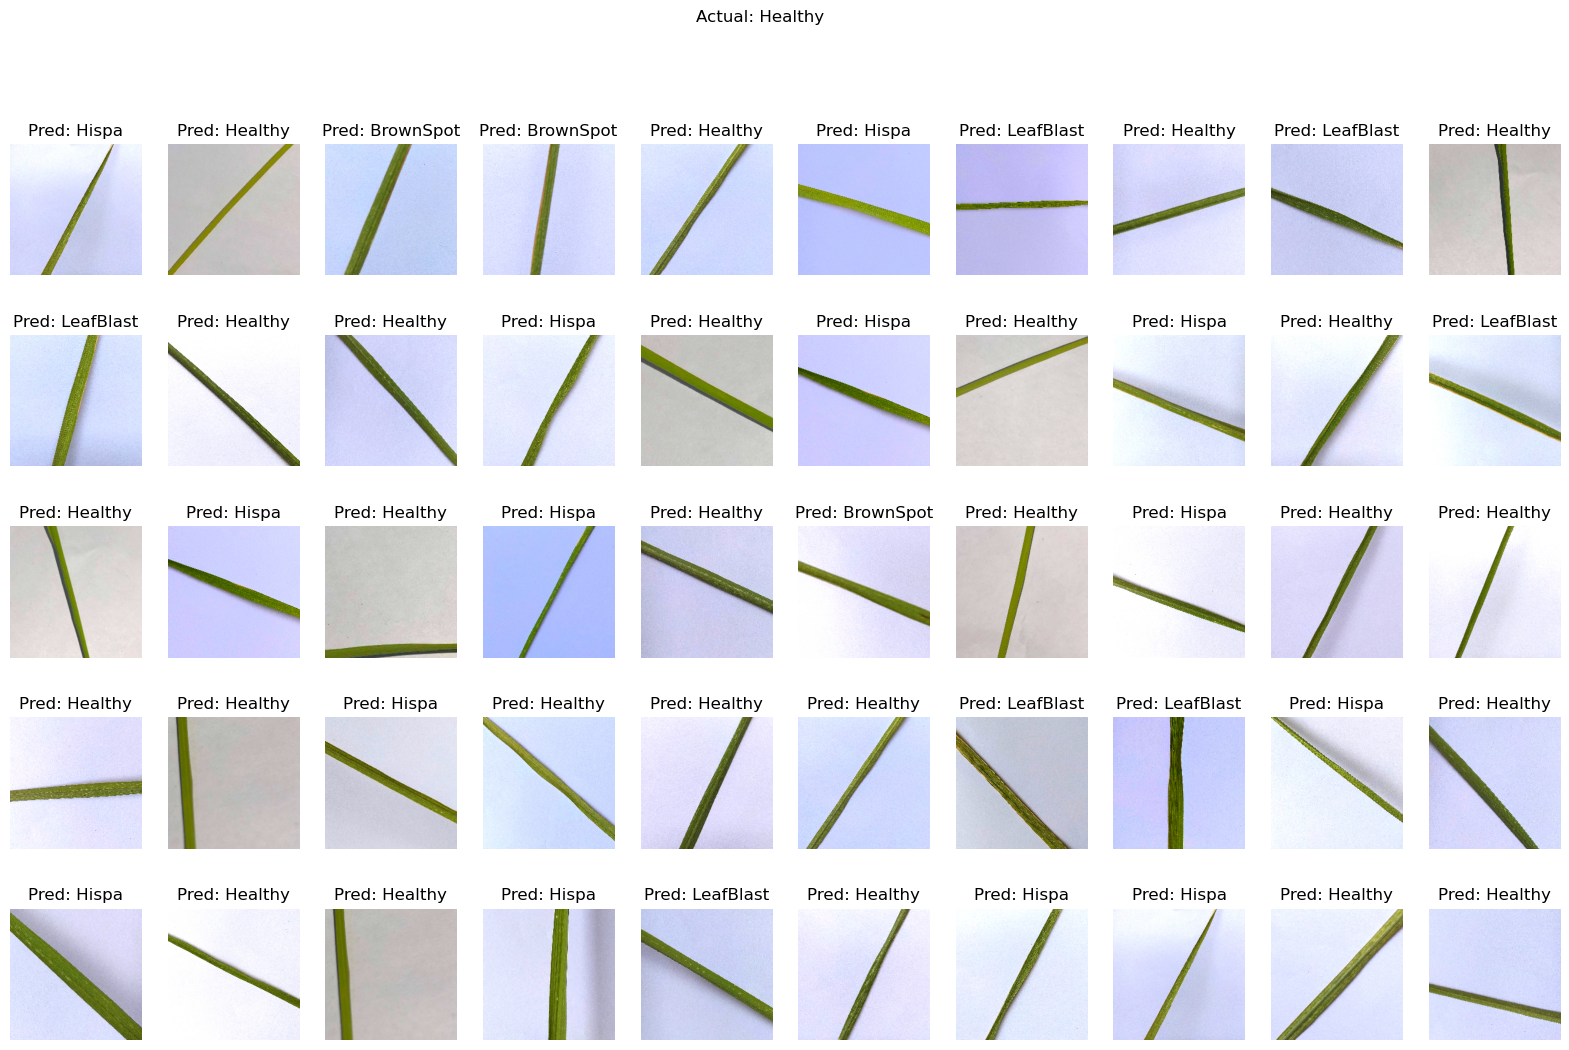

In [22]:
class_names = 'Healthy'

files = os.listdir(os.path.join(other_source, class_names))

print('Predicting...')

plt.figure(figsize=(20, 12))
for i in range(50):
    plt.subplot(5, 10, i+1)
    img = random.choice(files)
    img = os.path.join(other_source, class_names, img)
    img = image.load_img(img, target_size=(img_size, img_size))
    img = image.img_to_array(img)
    img = img/255.0
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img, verbose=0)
    plt.title('Pred: ' + target_names[np.argmax(prediction)])
    plt.axis('off')
plt.suptitle('Actual: ' + class_names)
plt.show()

Predicting...


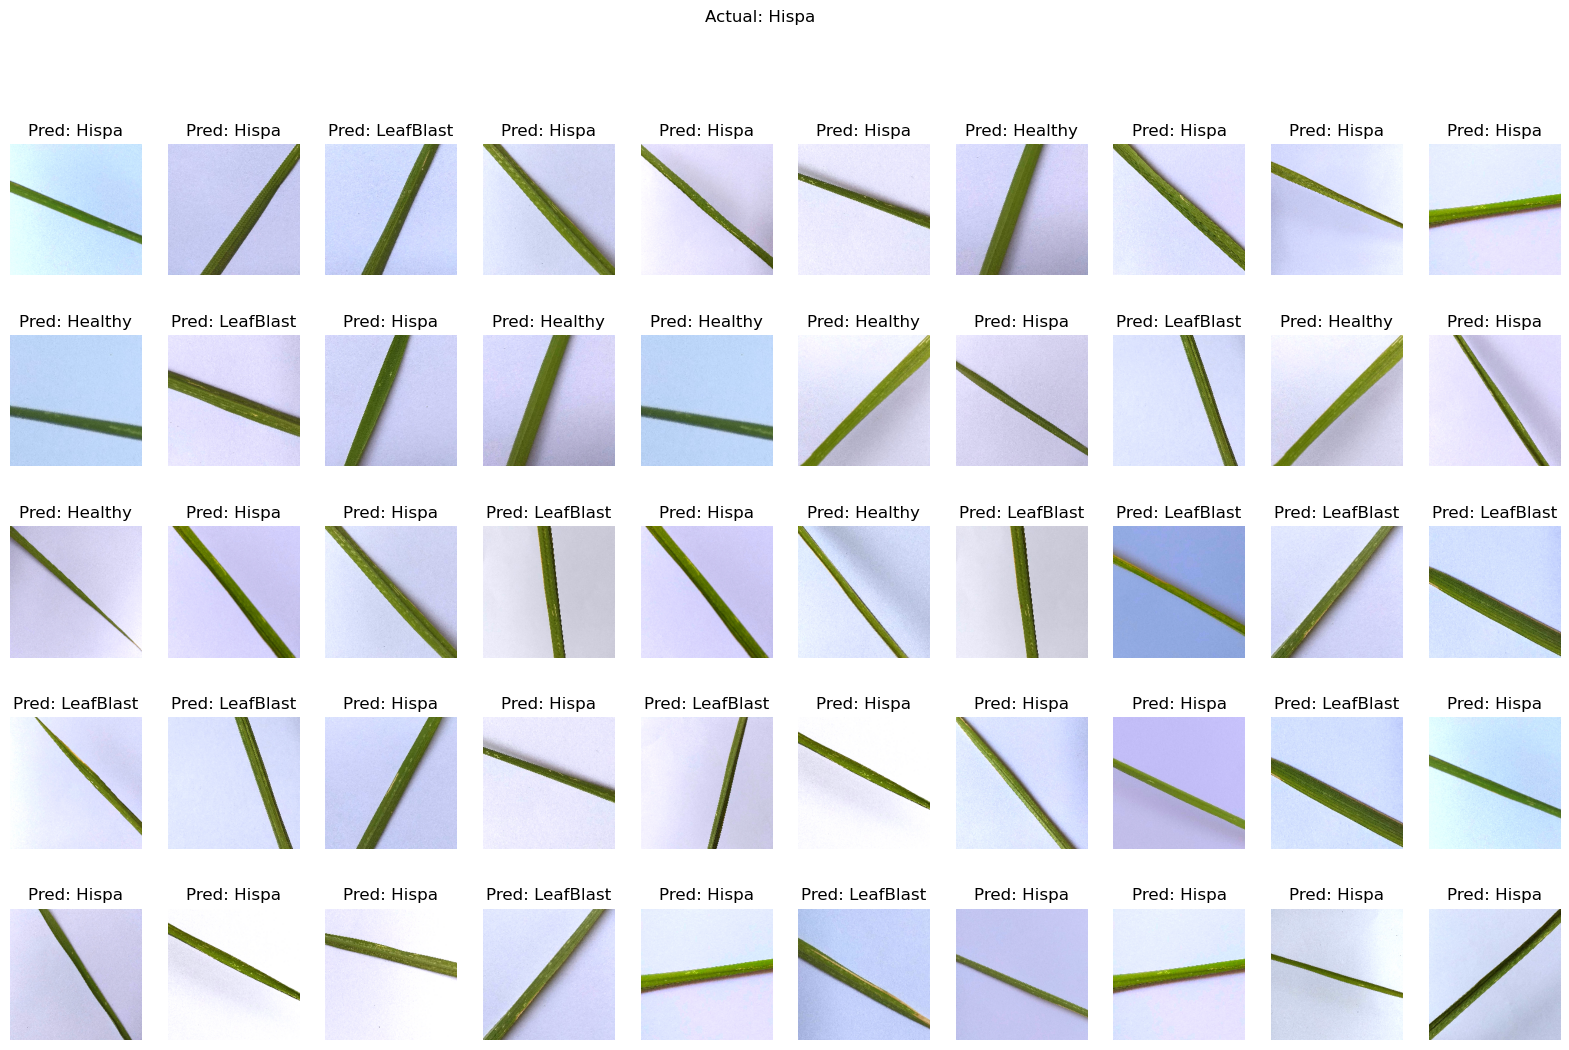

In [23]:
class_names = 'Hispa'

files = os.listdir(os.path.join(other_source, class_names))

print('Predicting...')

plt.figure(figsize=(20, 12))
for i in range(50):
    plt.subplot(5, 10, i+1)
    img = random.choice(files)
    img = os.path.join(other_source, class_names, img)
    img = image.load_img(img, target_size=(img_size, img_size))
    img = image.img_to_array(img)
    img = img/255.0
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img, verbose=0)
    plt.title('Pred: ' + target_names[np.argmax(prediction)])
    plt.axis('off')
plt.suptitle('Actual: ' + class_names)
plt.show()

Predicting...


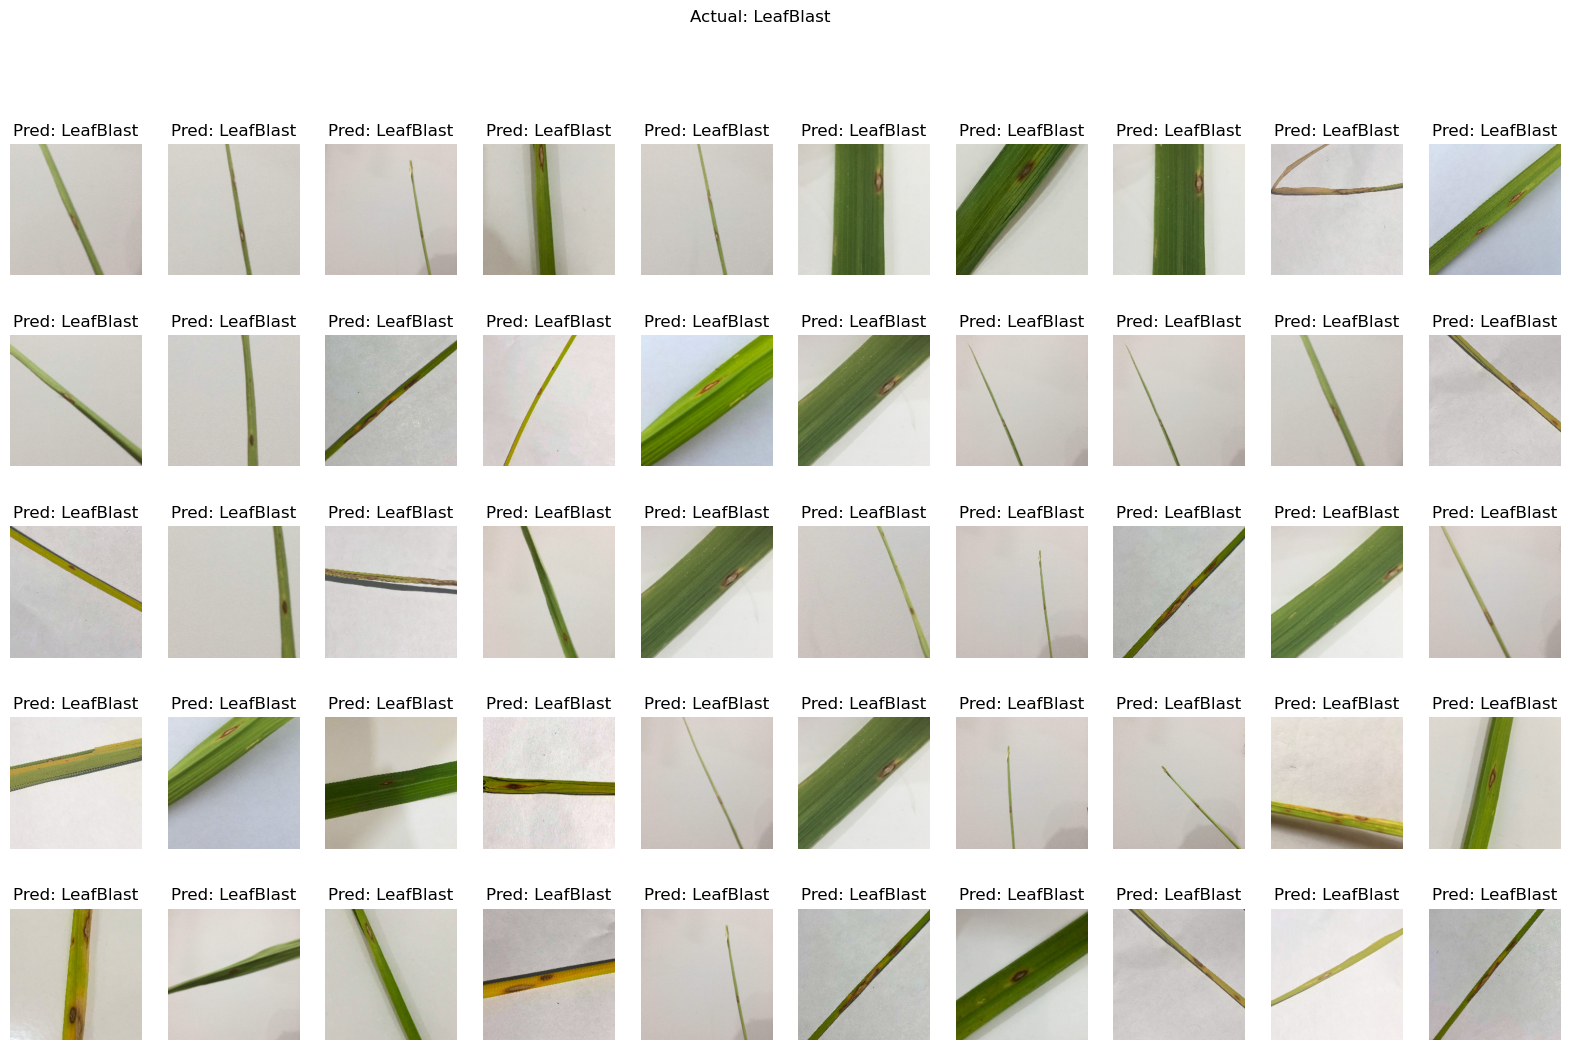

In [24]:
class_names = 'LeafBlast'

files = os.listdir(os.path.join(other_source, class_names))

print('Predicting...')

plt.figure(figsize=(20, 12))
for i in range(50):
    plt.subplot(5, 10, i+1)
    img = random.choice(files)
    img = os.path.join(other_source, class_names, img)
    img = image.load_img(img, target_size=(img_size, img_size))
    img = image.img_to_array(img)
    img = img/255.0
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img, verbose=0)
    plt.title('Pred: ' + target_names[np.argmax(prediction)])
    plt.axis('off')
plt.suptitle('Actual: ' + class_names)
plt.show()